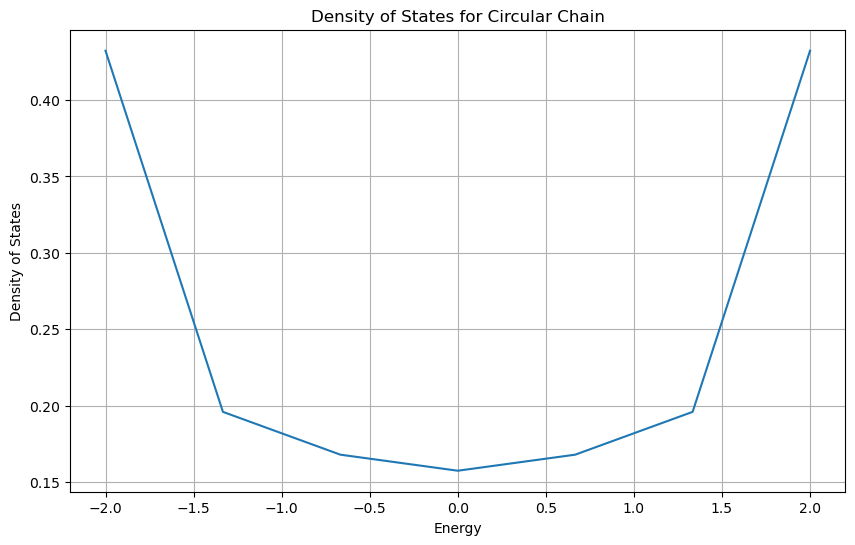

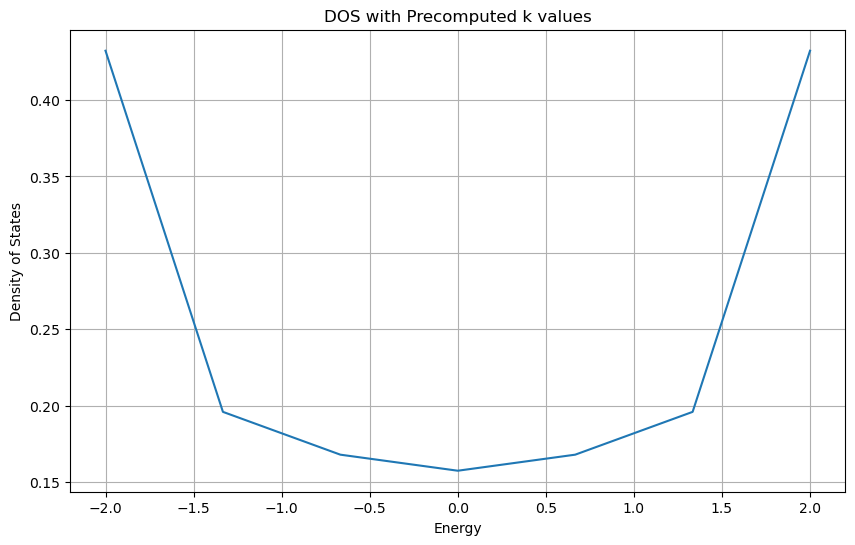

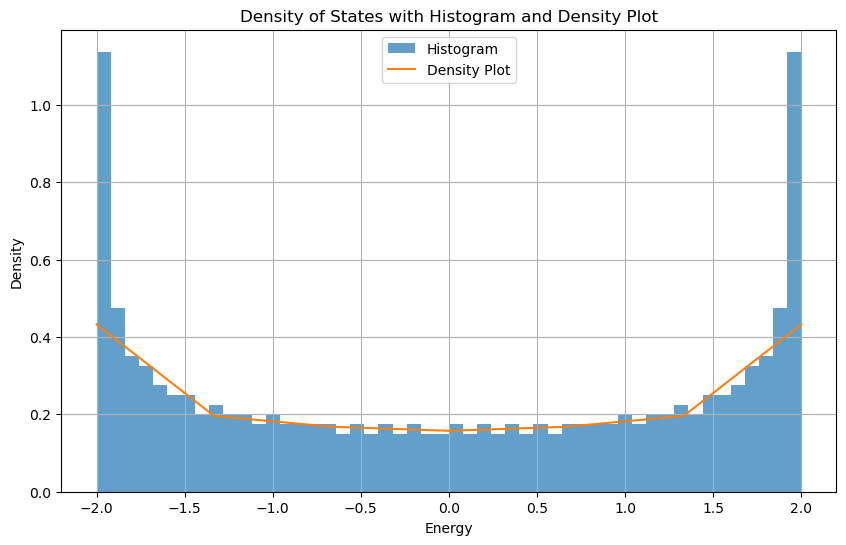

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

def circular_chain_dos(n_atoms, t, e_0=0, k_values=None, num_k=1000):
    """
    Calculates the density of states for a circular chain.

    Args:
        n_atoms (int): The number of atoms in the chain.
        t (float): The hopping parameter (tight-binding model).
        e_0 (float, optional): On-site energy. Defaults to 0.
        k_values (array-like, optional): Precomputed k values. If None,
                                        generates them using num_k.
        num_k (int, optional): Number of k values to generate.
                               Defaults to 1000.

    Returns:
        tuple: A tuple containing:
            - energies (numpy.ndarray): The calculated energy levels.
            - dos (numpy.ndarray): The density of states.
    """
    if k_values is None:
        k_values = np.linspace(-np.pi, np.pi, num_k, endpoint=False)
    energies = e_0 + 2 * t * np.cos(k_values)
    return energies, np.histogram(energies, bins=7, density=True)[0]



def plot_dos(energies, dos, title="Density of States for Circular Chain"):
    """
    Plots the density of states.

    Args:
        energies (numpy.ndarray): The energy levels.
        dos (numpy.ndarray): The density of states.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(energies.min(), energies.max(), len(dos)), dos)
    plt.xlabel("Energy")
    plt.ylabel("Density of States")
    plt.title(title)
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    # Example usage
    n_atoms = 100
    t = 1.0
    energies, dos = circular_chain_dos(n_atoms, t)
    plot_dos(energies, dos)


    # Example with precomputed k values:
    num_k = 1000
    k_values = np.linspace(-np.pi, np.pi, num_k, endpoint=False)
    energies_precomputed, dos_precomputed = circular_chain_dos(n_atoms, t, k_values=k_values)
    plot_dos(energies_precomputed, dos_precomputed, title="DOS with Precomputed k values")

    # Example with histogram and density plot:
    plt.figure(figsize=(10, 6))
    plt.hist(energies, bins=50, density=True, alpha=0.7, label="Histogram")
    plt.plot(np.linspace(energies.min(), energies.max(), len(dos)), dos, label="Density Plot")
    plt.xlabel("Energy")
    plt.ylabel("Density")
    plt.title("Density of States with Histogram and Density Plot")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import os

# Criar pasta para salvar gráficos
output_dir = "figuras"
os.makedirs(output_dir, exist_ok=True)

# Parâmetros do problema
k_const = 1.0
m_val = 1.0
m_defeito = 5.0 * m_val
N = 1000

# --- Parte 1: Cadeia homogênea (analítica) ---

def dos_analitico_circular(N, k_const, m_val, num_k=1000):
    k_vals = np.linspace(-np.pi, np.pi, num_k, endpoint=False)
    omega = 2 * np.sqrt(k_const / m_val) * np.abs(np.sin(k_vals / 2))
    dos, bins = np.histogram(omega, bins=50, density=True)
    freq_bins = (bins[:-1] + bins[1:]) / 2
    return freq_bins, dos

def plot_dos(freq_bins, dos, title, filename=None):
    plt.figure(figsize=(10,6))
    plt.plot(freq_bins, dos, label="Densidade de Estados")
    plt.xlabel("Frequência (rad/s)")
    plt.ylabel("Densidade")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

# --- Parte 2: Cadeia com defeito (matriz dinâmica) ---

def construir_matriz_dinamica(N, defeito=False):
    M = np.ones(N) * m_val
    if defeito:
        M[N // 2] = m_defeito
    D = np.zeros((N, N))
    for i in range(N):
        D[i, i] = 2 * k_const / M[i]
        D[i, (i - 1) % N] = -k_const / M[i]
        D[i, (i + 1) % N] = -k_const / M[i]
    return D

def calcular_frequencias(D):
    w2, _ = eigh(D)
    w = np.sqrt(np.abs(w2))
    return w

def plotar_histograma(w, N, com_defeito, filename=None):
    plt.figure(figsize=(10,6))
    plt.hist(w, bins=50, density=True, alpha=0.7, color='steelblue', label="Histograma")
    plt.xlabel("Frequência (rad/s)")
    plt.ylabel("Densidade")
    plt.title(f"Densidade de Estados - N={N} " + ("(com defeito)" if com_defeito else "(homogêneo)"))
    plt.grid(True)
    plt.legend()
    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

# --- Execução ---

# Cadeia homogênea analítica
freq_bins, dos = dos_analitico_circular(N, k_const, m_val)
plot_dos(freq_bins, dos, "DOS Analítico - Cadeia Circular Homogênea", 
         filename=os.path.join(output_dir, "dos_analitico_homogeneo.png"))

# Cadeia com defeito (matriz dinâmica)
D_defeito = construir_matriz_dinamica(N, defeito=True)
w_defeito = calcular_frequencias(D_defeito)
plotar_histograma(w_defeito, N, com_defeito=True, filename=os.path.join(output_dir, "dos_defeito.png"))

# Cadeia homogênea (matriz dinâmica) para comparação
D_homogenea = construir_matriz_dinamica(N, defeito=False)
w_homogenea = calcular_frequencias(D_homogenea)
plotar_histograma(w_homogenea, N, com_defeito=False, filename=os.path.join(output_dir, "dos_homogeneo.png"))

print("Gráficos salvos na pasta 'figuras'.")


Gráficos salvos na pasta 'figuras'.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.stats import gaussian_kde
import os

# Criar pasta para salvar gráficos
output_dir = "figuras"
os.makedirs(output_dir, exist_ok=True)

k = 1.0         # Constante elástica (N/m)
m_val = 1.0     # Massa padrão (kg)
m_defeito = 5.0 * m_val

def construir_matriz_dinamica(N, defeito=False):
    M = np.ones(N) * m_val
    if defeito:
        M[N // 2] = m_defeito

    D = np.zeros((N, N))
    for i in range(N):
        D[i, i] = 2 * k / M[i]
        D[i, (i - 1) % N] = -k / M[i]
        D[i, (i + 1) % N] = -k / M[i]
    return D

def calcular_frequencias_modos(D):
    w2, modos = eigh(D)
    w = np.sqrt(np.abs(w2))
    return w, modos

def plotar_histograma_e_kde(w, N, com_defeito):
    plt.figure(figsize=(10, 6))
    
    # Histograma com bins maiores para mais resolução
    bins = 50
    plt.hist(w, bins=bins, density=True, alpha=0.5, color='steelblue', label='Histograma')
    
    # KDE para suavizar a densidade
    kde = gaussian_kde(w)
    w_linspace = np.linspace(min(w), max(w), 1000)
    plt.plot(w_linspace, kde(w_linspace), color='darkorange', lw=2, label='KDE Suavizado')
    
    titulo = f"Densidade de Estados - N={N} " + ("(com defeito)" if com_defeito else "(homogêneo)")
    plt.title(titulo)
    plt.xlabel("Frequência (rad/s)")
    plt.ylabel("Densidade")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    filename = f"histograma_kde_N{N}_{'defeito' if com_defeito else 'homogeneo'}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()
    return filename

def plotar_modos_normais(modos, N, w, tipo, qtd=5):
    indices = np.argsort(w)
    if tipo == "baixas":
        indices = indices[:qtd]
    else:
        indices = indices[-qtd:]

    plt.figure(figsize=(10, 6))
    for i in indices:
        plt.plot(modos[:, i], label=f'Modo {i} - f={w[i]:.2f}')
    plt.title(f'Modos de {"Baixa" if tipo=="baixas" else "Alta"} Frequência - N={N}')
    plt.xlabel("Índice da Massa")
    plt.ylabel("Deslocamento Relativo")
    plt.legend()
    plt.tight_layout()
    filename = f"modos_{tipo}_N{N}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()
    return filename

# Execução principal
resultados = {}
N = 1000

for defeito in [False, True]:
    D = construir_matriz_dinamica(N, defeito=defeito)
    w, modos = calcular_frequencias_modos(D)
    
    hist_fig = plotar_histograma_e_kde(w, N, com_defeito=defeito)
    modos_baixos = plotar_modos_normais(modos, N, w, "baixas")
    modos_altos = plotar_modos_normais(modos, N, w, "altas")

    resultados[f"N={N}, defeito={defeito}"] = {
        "frequencias": w,
        "modos": modos,
        "histograma": hist_fig,
        "modos_baixos": modos_baixos,
        "modos_altos": modos_altos
    }

print("Simulações finalizadas e gráficos salvos na pasta 'figuras'.")


Simulações finalizadas e gráficos salvos na pasta 'figuras'.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import os

# Criar pasta para salvar gráficos
output_dir = "figuras"
os.makedirs(output_dir, exist_ok=True)

k = 1.0
m_val = 1.0
m_defeito = 5.0 * m_val

def construir_matriz_dinamica(N, defeito=False):
    M = np.ones(N) * m_val
    if defeito:
        M[N // 2] = m_defeito

    D = np.zeros((N, N))
    for i in range(N):
        D[i, i] = 2 * k / M[i]
        D[i, (i - 1) % N] = -k / M[i]
        D[i, (i + 1) % N] = -k / M[i]
    return D

def calcular_frequencias(D):
    w2, _ = eigh(D)
    w = np.sqrt(np.abs(w2))
    return w

def dos_fft_suavizada(w, N_bins=7, freq_max=None):
    # Define a grade uniforme para o espectro
    if freq_max is None:
        freq_max = w.max() * 1.1
    freq_min = 0
    freqs_lin = np.linspace(freq_min, freq_max, N_bins)

    # Criar vetor "sinal" do espectro: contar autovalores no bin mais próximo
    sinal = np.zeros(N_bins)
    indices = np.searchsorted(freqs_lin, w) - 1
    indices = np.clip(indices, 0, N_bins - 1)
    np.add.at(sinal, indices, 1)

    # FFT do sinal para suavizar
    fft_sinal = np.abs(np.fft.fft(sinal))
    fft_sinal = fft_sinal[:N_bins // 2]  # metade positiva da FFT

    # Escala o eixo de frequência da FFT para DOS
    freq_fft = np.fft.fftfreq(N_bins, d=(freqs_lin[1] - freqs_lin[0]))[:N_bins // 2]

    # Normalizar
    fft_sinal = fft_sinal / np.trapz(fft_sinal, freq_fft)

    return freq_fft, fft_sinal

def plotar_dos_fft_histograma(w, N, com_defeito):
    plt.figure(figsize=(10,6))
    # Histograma tradicional
    plt.hist(w, bins=7, density=True, alpha=0.5, label="Histograma")

    # DOS suavizada FFT
    freq_fft, dos_smooth = dos_fft_suavizada(w)
    plt.plot(freq_fft, dos_smooth, color='red', lw=2, label='DOS suavizada via FFT')

    plt.xlabel("Frequência (rad/s)")
    plt.ylabel("Densidade")
    plt.title(f"Densidade de Estados - N={N} " + ("(com defeito)" if com_defeito else "(homogêneo)"))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    filename = f"histograma_fft_N{N}_{'defeito' if com_defeito else 'homogeneo'}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()
    return filename

# Execução principal
resultados = {}
N = 1000

for defeito in [False, True]:
    D = construir_matriz_dinamica(N, defeito=defeito)
    w = calcular_frequencias(D)
    hist_fft_fig = plotar_dos_fft_histograma(w, N, com_defeito=defeito)

    resultados[f"N={N}, defeito={defeito}"] = {
        "frequencias": w,
        "histograma_fft": hist_fft_fig,
    }

print("Simulações finalizadas e gráficos salvos na pasta 'figuras'.")


Simulações finalizadas e gráficos salvos na pasta 'figuras'.
